In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import pandas as pd
import pprint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import csv
import json
import seaborn as sns
from scipy import stats
from scipy.ndimage.filters import gaussian_filter

mpl.rcParams['figure.dpi'] = 144
mpl.rcParams['figure.figsize'] = (10, 7)

DATA_DIR = "/Users/jeremygordon/Google Drive/Academic/# UC Berkeley ISchool PhD/Research/# Current/Covert Embodied Choice/Data"

## Load data frames (generated by build_dfs.ipynb)

In [7]:
trial_df = pd.read_pickle(DATA_DIR + '/frames/trial_df.pickle')
tracking_df = pd.read_pickle(DATA_DIR + '/frames/tracking_df.pickle')
fixation_df = pd.read_pickle(DATA_DIR + '/frames/fixation_df.pickle')
subject_df = pd.read_pickle(DATA_DIR + '/frames/subject_df.pickle')
with open("../ExperimentData/hands.json") as f:
    HANDS = json.load(f)

## Analyses

In [8]:
tracking_df

,hmd_yaw,hmd_roll,hmd_pitch,hmd_x,hmd_y,hmd_z,ctr_yaw,ctr_roll,ctr_pitch,ctr_x,...,gaze_or_z,gaze_dir_x,gaze_dir_y,gaze_dir_z,gaze_tgt_x,gaze_tgt_y,gaze_tgt_z,gaze_conv_dist,blinking,ts
DEBUG_1580681691.078,0.016197,2.958205,-0.237786,0.019763,0.987959,-0.120874,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,False,1.580682e+09
DEBUG_1580681691.143,0.016197,2.958205,-0.237786,0.019763,0.987959,-0.120874,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,False,1.580682e+09
DEBUG_1580681692.099,0.016158,2.958159,-0.237826,0.019748,0.987955,-0.120893,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,False,1.580682e+09
DEBUG_1580681692.139,0.014346,2.961933,-0.239555,0.018651,0.988078,-0.121602,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,False,1.580682e+09
DEBUG_1580681692.150,0.014200,2.961807,-0.239442,0.018577,0.988082,-0.121541,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,False,1.580682e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DEBUG_1580681758.030,0.047604,-0.312188,0.550011,0.285351,-0.183062,0.081118,-0.221865,-0.256912,0.400243,0.188143,...,1.329254,0.070035,-0.646183,0.759951,0.029803,0.398412,1.738094,0.537982,False,1.580682e+09
DEBUG_1580681758.041,0.046452,-0.310308,0.554295,0.287242,-0.182267,0.080663,-0.222075,-0.260647,0.389974,0.182916,...,1.333610,0.083831,-0.627180,0.774330,0.116679,-0.140287,2.427804,1.413086,False,1.580682e+09
DEBUG_1580681758.052,0.044173,-0.309137,0.559460,0.289546,-0.181774,0.079790,-0.226056,-0.263373,0.375767,0.175427,...,1.336417,0.073676,-0.629457,0.773515,0.102933,-0.112946,2.392304,1.365051,False,1.580682e+09
DEBUG_1580681758.063,0.042122,-0.307603,0.564942,0.291994,-0.181143,0.079022,-0.232413,-0.267987,0.361151,0.167480,...,1.339511,0.066819,-0.626004,0.776934,0.096605,-0.086915,2.374320,1.331914,False,1.580682e+09


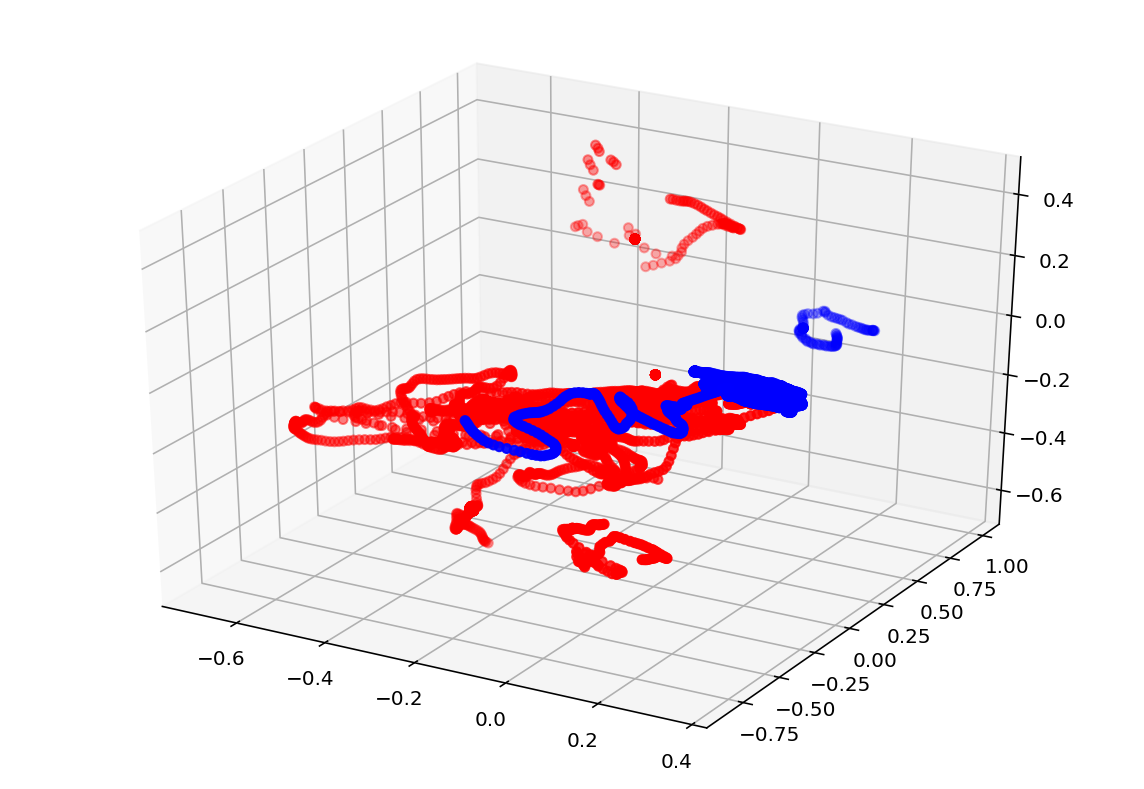

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tracking_df['hmd_x'], tracking_df['hmd_y'], tracking_df['hmd_z'], c='blue')
ax.scatter(tracking_df['ctr_x'], tracking_df['ctr_y'], tracking_df['ctr_z'], c='red')